# 量化金融预测

In [1]:
# 导入模块
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, KFold, GroupKFold
from sklearn.metrics import accuracy_score,f1_score, roc_auc_score
from sklearn.metrics import log_loss, mean_squared_log_error
from catboost import CatBoostClassifier
import tqdm, sys, os, gc, argparse, warnings
import matplotlib.pyplot as plt

c:\Users\OneRaise\miniconda3\Lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\OneRaise\miniconda3\Lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\OneRaise\miniconda3\Lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-246-g3d31191b-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# 数据导入
train_file = os.listdir('../input/train/')
test_file = os.listdir('../input/test/')
train = pd.DataFrame()
test = pd.DataFrame()
# 读取训练数据
for file in train_file:
    tmp = pd.read_csv('../input/train/'+file)
    tmp['file'] = file
    train = pd.concat([train, tmp], axis=0, ignore_index=True)
# 读取测试数据
for file in test_file:
    tmp = pd.read_csv('../input/test/'+file)
    tmp['file'] = file
    test = pd.concat([test, tmp], axis=0, ignore_index=True)


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239880 entries, 0 to 239879
Data columns (total 33 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   uuid          239880 non-null  int64  
 1   date          239880 non-null  int64  
 2   time          239880 non-null  object 
 3   sym           239880 non-null  int64  
 4   n_close       239880 non-null  float64
 5   amount_delta  239880 non-null  float64
 6   n_midprice    239880 non-null  float64
 7   n_bid1        239880 non-null  float64
 8   n_bsize1      239880 non-null  float64
 9   n_bid2        239880 non-null  float64
 10  n_bsize2      239880 non-null  float64
 11  n_bid3        239880 non-null  float64
 12  n_bsize3      239880 non-null  float64
 13  n_bid4        239880 non-null  float64
 14  n_bsize4      239880 non-null  float64
 15  n_bid5        239880 non-null  float64
 16  n_bsize5      239880 non-null  float64
 17  n_ask1        239880 non-null  float64
 18  n_as

In [4]:
train.head()

,uuid,date,time,sym,n_close,amount_delta,n_midprice,n_bid1,n_bsize1,n_bid2,...,n_ask4,n_asize4,n_ask5,n_asize5,label_5,label_10,label_20,label_40,label_60,file
0,0,0,09:40:03,1,-0.007605,2081.0,-0.009506,-0.011407,0.000222,-0.015209,...,0.003802,0.000162,0.007605,0.000262,1,0,0,0,1,snapshot_sym1_date0_am.csv
1,1,0,09:40:06,1,-0.011407,129268.0,-0.009506,-0.011407,0.000221,-0.015209,...,0.003802,0.000163,0.007605,0.000264,1,0,0,0,1,snapshot_sym1_date0_am.csv
2,2,0,09:40:09,1,-0.007605,76098.0,-0.009506,-0.011407,0.000221,-0.015209,...,0.003802,0.000163,0.007605,0.000265,0,0,0,0,1,snapshot_sym1_date0_am.csv
3,3,0,09:40:12,1,-0.007605,2613280.0,-0.009506,-0.011407,0.000174,-0.015209,...,0.003802,0.000162,0.007605,0.000265,0,0,0,0,1,snapshot_sym1_date0_am.csv
4,4,0,09:40:15,1,-0.011407,327615.0,-0.009506,-0.011407,0.000112,-0.015209,...,0.003802,0.000162,0.007605,0.000265,0,0,0,0,1,snapshot_sym1_date0_am.csv


In [5]:
train.describe()

,uuid,date,sym,n_close,amount_delta,n_midprice,n_bid1,n_bsize1,n_bid2,n_bsize2,...,n_asize3,n_ask4,n_asize4,n_ask5,n_asize5,label_5,label_10,label_20,label_40,label_60
count,239880.000000,239880.000000,239880.0,239880.000000,2.398800e+05,239880.000000,239880.000000,2.398800e+05,239880.000000,2.398800e+05,...,239880.000000,239880.000000,239880.000000,239880.000000,239880.000000,239880.000000,239880.000000,239880.000000,239880.000000,239880.000000
mean,999.000000,29.783333,1.0,0.006398,8.518432e+05,0.006367,0.004891,3.757366e-04,0.001828,3.144186e-04,...,0.000309,0.012272,0.000307,0.014930,0.000294,1.001401,1.000913,0.998424,0.997457,0.996790
std,577.062725,17.671663,0.0,0.028634,7.481202e+06,0.028595,0.028756,9.289055e-04,0.028720,1.877919e-04,...,0.000241,0.021109,0.000252,0.020870,0.000231,0.320780,0.398801,0.488519,0.585648,0.640166
min,0.000000,0.000000,1.0,-0.081818,0.000000e+00,-0.082955,-0.084091,2.873695e-09,-0.086364,2.873695e-09,...,0.000000,-0.075000,0.000000,-0.072727,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,499.000000,14.750000,1.0,-0.007752,3.559225e+04,-0.008861,-0.010127,7.660985e-05,-0.012658,1.661127e-04,...,0.000143,0.000000,0.000149,0.002597,0.000151,1.000000,1.000000,1.000000,1.000000,1.000000
50%,999.000000,29.500000,1.0,0.002457,2.013915e+05,0.001873,0.000000,1.668456e-04,-0.003731,2.845122e-04,...,0.000294,0.011450,0.000289,0.015038,0.000279,1.000000,1.000000,1.000000,1.000000,1.000000
75%,1499.000000,45.250000,1.0,0.013908,7.295142e+05,0.013672,0.011719,3.246684e-04,0.009259,4.264966e-04,...,0.000427,0.022113,0.000411,0.024000,0.000392,1.000000,1.000000,1.000000,1.000000,1.000000
max,1998.000000,60.000000,1.0,0.100239,3.440177e+09,0.100239,0.100239,7.819406e-03,0.097852,1.138172e-03,...,0.004537,0.100239,0.004548,0.100239,0.004616,2.000000,2.000000,2.000000,2.000000,2.000000


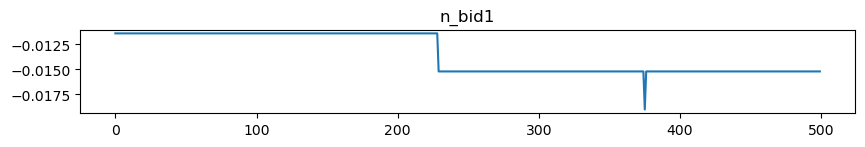

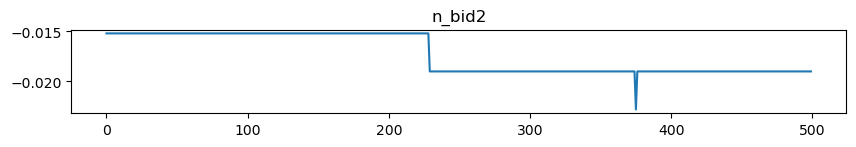

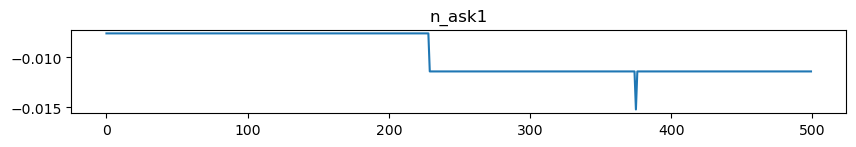

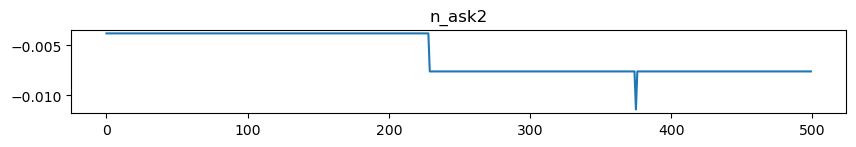

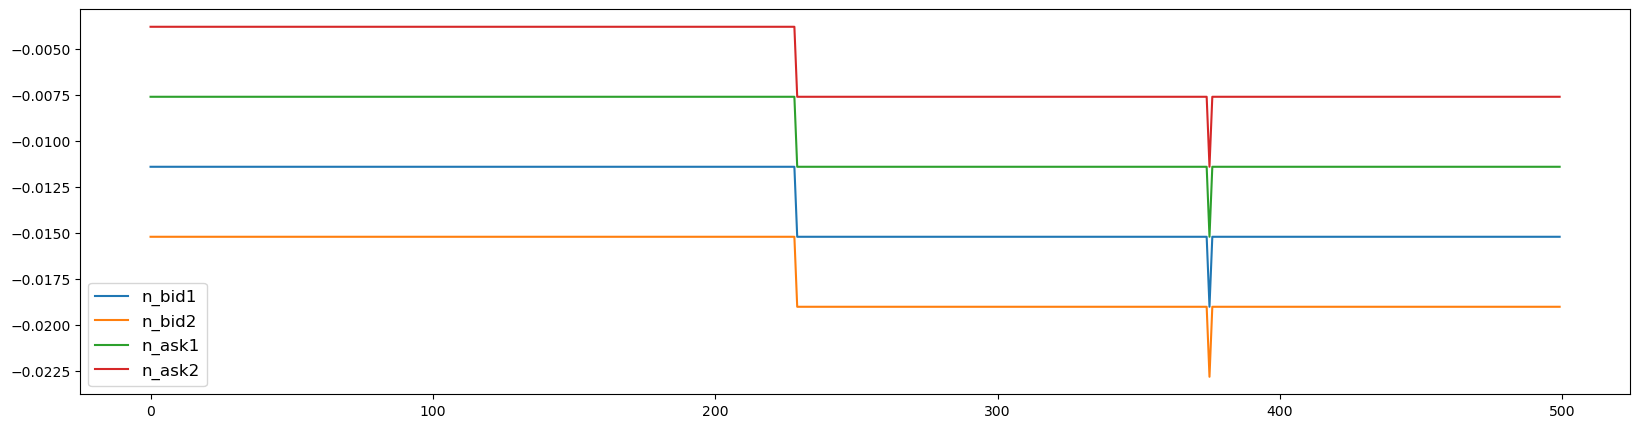

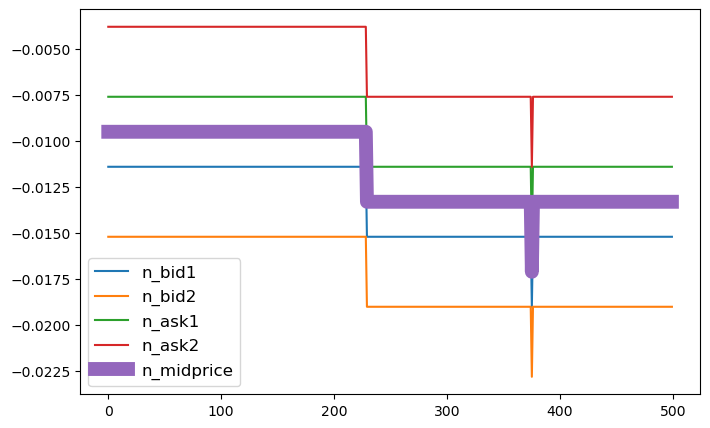

In [6]:
cols = ['n_bid1','n_bid2','n_ask1','n_ask2']
tmp_df = train[train['file']=='snapshot_sym1_date0_am.csv'].reset_index(drop=True)[-500:]
tmp_df = tmp_df.reset_index(drop=True).reset_index()
for num, col in enumerate(cols):
    plt.figure(figsize=(10,5))
    plt.subplot(4,1,num+1)
    plt.plot(tmp_df['index'],tmp_df[col])
    plt.title(col)
plt.show()

plt.figure(figsize=(20,5))
for num, col in enumerate(cols):
    plt.plot(tmp_df['index'],tmp_df[col],label=col)
plt.legend(fontsize=12)

plt.figure(figsize=(8,5))
for num, col in enumerate(cols):
    plt.plot(tmp_df['index'],tmp_df[col],label=col)

plt.plot(tmp_df['index'],tmp_df['n_midprice'],label="n_midprice",lw=10)
plt.legend(fontsize=12)

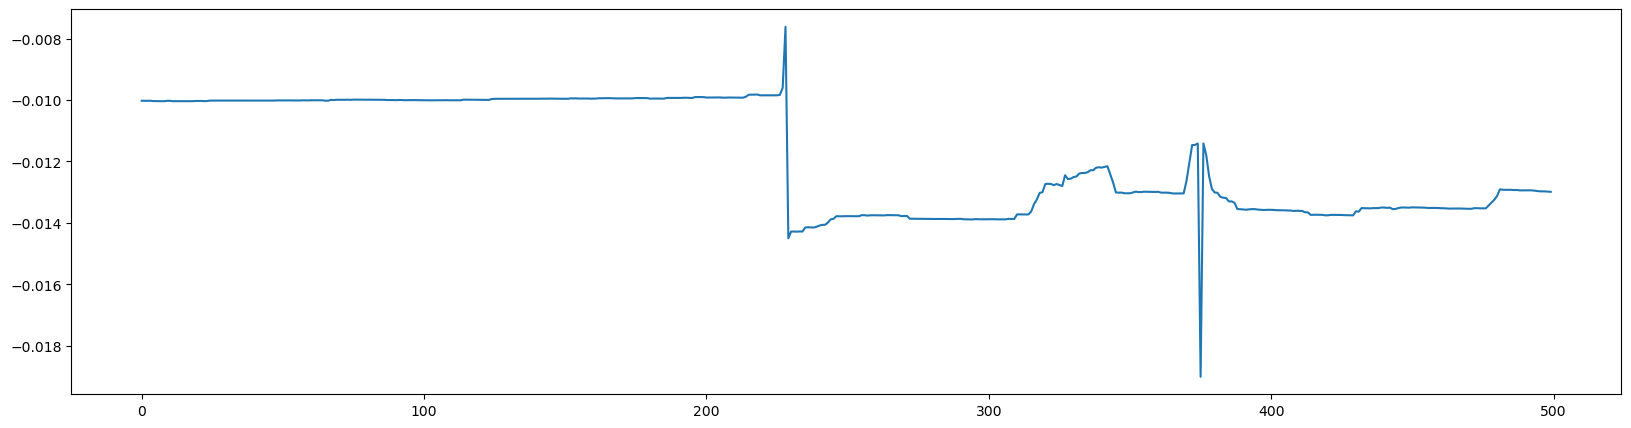

In [7]:
train['wap1'] = (train['n_bid1']*train['n_bsize1'] + train['n_ask1']*train['n_asize1'])/(train['n_bsize1'] + train['n_asize1'])
test['wap1'] = (test['n_bid1']*test['n_bsize1'] + test['n_ask1']*test['n_asize1'])/(test['n_bsize1'] + test['n_asize1'])

tmp_df = train[train['file']=='snapshot_sym1_date0_am.csv'].reset_index(drop=True)[-500:]
tmp_df = tmp_df.reset_index(drop=True).reset_index()
plt.figure(figsize=(20,5))
plt.plot(tmp_df['index'], tmp_df['wap1'])

In [8]:
# 时间相关特征
train['hour'] = train['time'].apply(lambda x:int(x.split(':')[0]))
test['hour'] = test['time'].apply(lambda x:int(x.split(':')[0]))

train['minute'] = train['time'].apply(lambda x:int(x.split(':')[1]))
test['minute'] = test['time'].apply(lambda x:int(x.split(':')[1]))

# 入模特征
cols = [f for f in test.columns if f not in ['uuid','time','file']]

In [9]:
def cv_model(clf, train_x, train_y, test_x, clf_name, seed = 2023):
    folds = 5
    kf = KFold(n_splits=folds, shuffle=True, random_state=seed)
    oof = np.zeros([train_x.shape[0], 3])
    test_predict = np.zeros([test_x.shape[0], 3])
    cv_scores = []
    
    for i, (train_index, valid_index) in enumerate(kf.split(train_x, train_y)):
        print('************************************ {} ************************************'.format(str(i+1)))
        trn_x, trn_y, val_x, val_y = train_x.iloc[train_index], train_y[train_index], train_x.iloc[valid_index], train_y[valid_index]
       
        if clf_name == "cat":
            params = {'learning_rate': 0.2, 'depth': 6, 'bootstrap_type':'Bernoulli','random_seed':2023,
                      'od_type': 'Iter', 'od_wait': 100, 'random_seed': 11, 'allow_writing_files': False,
                      'loss_function': 'MultiClass'}
            
            model = clf(iterations=100, **params)
            model.fit(trn_x, trn_y, eval_set=(val_x, val_y),
                      metric_period=20,
                      use_best_model=True, 
                      cat_features=[],
                      verbose=1)
            
            val_pred  = model.predict_proba(val_x)
            test_pred = model.predict_proba(test_x)
        
        oof[valid_index] = val_pred
        test_predict += test_pred / kf.n_splits
        
        F1_score = f1_score(val_y, np.argmax(val_pred, axis=1), average='macro')
        cv_scores.append(F1_score)
        print(cv_scores)
        
    return oof, test_predict
    
for label in ['label_5','label_10','label_20','label_40','label_60']:
    print(f'=================== {label} ===================')
    cat_oof, cat_test = cv_model(CatBoostClassifier, train[cols], train[label], test[cols], 'cat')
    train[label] = np.argmax(cat_oof, axis=1)
    test[label] = np.argmax(cat_test, axis=1)

=================== label_5 ===================
************************************ 1 ************************************


0:	learn: 0.7412933	test: 0.7412690	best: 0.7412690 (0)	total: 209ms	remaining: 20.7s
20:	learn: 0.0091393	test: 0.0091390	best: 0.0091390 (20)	total: 959ms	remaining: 3.61s
40:	learn: 0.0002625	test: 0.0002621	best: 0.0002621 (40)	total: 1.73s	remaining: 2.49s
60:	learn: 0.0000464	test: 0.0000464	best: 0.0000464 (60)	total: 2.7s	remaining: 1.73s
80:	learn: 0.0000257	test: 0.0000257	best: 0.0000257 (80)	total: 3.6s	remaining: 845ms
99:	learn: 0.0000186	test: 0.0000188	best: 0.0000188 (99)	total: 4.33s	remaining: 0us

bestTest = 1.87562727e-05
bestIteration = 99

[1.0]
************************************ 2 ************************************


c:\Users\OneRaise\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\OneRaise\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\OneRaise\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\OneRaise\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_e

0:	learn: 0.7413181	test: 0.7413423	best: 0.7413423 (0)	total: 41.1ms	remaining: 4.07s
20:	learn: 0.0091385	test: 0.0091406	best: 0.0091406 (20)	total: 818ms	remaining: 3.08s
40:	learn: 0.0002727	test: 0.0002736	best: 0.0002736 (40)	total: 1.63s	remaining: 2.34s
60:	learn: 0.0000479	test: 0.0000482	best: 0.0000482 (60)	total: 2.37s	remaining: 1.52s
80:	learn: 0.0000265	test: 0.0000267	best: 0.0000267 (80)	total: 3.13s	remaining: 735ms
99:	learn: 0.0000192	test: 0.0000194	best: 0.0000194 (99)	total: 3.82s	remaining: 0us

bestTest = 1.938986576e-05
bestIteration = 99

[1.0, 1.0]
************************************ 3 ************************************


c:\Users\OneRaise\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\OneRaise\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\OneRaise\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\OneRaise\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_e

0:	learn: 0.7413177	test: 0.7412979	best: 0.7412979 (0)	total: 37.4ms	remaining: 3.7s
20:	learn: 0.0091395	test: 0.0091385	best: 0.0091385 (20)	total: 790ms	remaining: 2.97s
40:	learn: 0.0002630	test: 0.0002624	best: 0.0002624 (40)	total: 1.58s	remaining: 2.27s
60:	learn: 0.0000458	test: 0.0000457	best: 0.0000457 (60)	total: 2.66s	remaining: 1.7s
80:	learn: 0.0000253	test: 0.0000252	best: 0.0000252 (80)	total: 3.45s	remaining: 810ms
99:	learn: 0.0000184	test: 0.0000183	best: 0.0000183 (99)	total: 4.16s	remaining: 0us

bestTest = 1.833982661e-05
bestIteration = 99

[1.0, 1.0, 1.0]
************************************ 4 ************************************


c:\Users\OneRaise\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\OneRaise\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\OneRaise\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\OneRaise\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_e

0:	learn: 0.7413170	test: 0.7413298	best: 0.7413298 (0)	total: 41ms	remaining: 4.06s
20:	learn: 0.0091399	test: 0.0091411	best: 0.0091411 (20)	total: 811ms	remaining: 3.05s
40:	learn: 0.0002623	test: 0.0002622	best: 0.0002622 (40)	total: 1.57s	remaining: 2.26s
60:	learn: 0.0000480	test: 0.0000475	best: 0.0000475 (60)	total: 2.32s	remaining: 1.48s
80:	learn: 0.0000268	test: 0.0000263	best: 0.0000263 (80)	total: 3.1s	remaining: 728ms
99:	learn: 0.0000195	test: 0.0000190	best: 0.0000190 (99)	total: 3.82s	remaining: 0us

bestTest = 1.904513126e-05
bestIteration = 99

[1.0, 1.0, 1.0, 1.0]
************************************ 5 ************************************


c:\Users\OneRaise\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\OneRaise\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\OneRaise\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\OneRaise\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_e

0:	learn: 0.7413161	test: 0.7413443	best: 0.7413443 (0)	total: 40.2ms	remaining: 3.98s
20:	learn: 0.0091367	test: 0.0091394	best: 0.0091394 (20)	total: 817ms	remaining: 3.08s
40:	learn: 0.0002581	test: 0.0002590	best: 0.0002590 (40)	total: 1.85s	remaining: 2.66s
60:	learn: 0.0000407	test: 0.0000413	best: 0.0000413 (60)	total: 2.7s	remaining: 1.72s
80:	learn: 0.0000217	test: 0.0000221	best: 0.0000221 (80)	total: 3.5s	remaining: 822ms
99:	learn: 0.0000155	test: 0.0000159	best: 0.0000159 (99)	total: 4.24s	remaining: 0us

bestTest = 1.586759435e-05
bestIteration = 99

[1.0, 1.0, 1.0, 1.0, 1.0]
=================== label_10 ===================
************************************ 1 ************************************


c:\Users\OneRaise\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\OneRaise\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\OneRaise\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\OneRaise\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_e

0:	learn: 0.7409797	test: 0.7409781	best: 0.7409781 (0)	total: 43.3ms	remaining: 4.29s
20:	learn: 0.0091269	test: 0.0091250	best: 0.0091250 (20)	total: 1.07s	remaining: 4.01s
40:	learn: 0.0002609	test: 0.0002606	best: 0.0002606 (40)	total: 1.94s	remaining: 2.8s
60:	learn: 0.0000466	test: 0.0000467	best: 0.0000467 (60)	total: 2.68s	remaining: 1.71s
80:	learn: 0.0000250	test: 0.0000250	best: 0.0000250 (80)	total: 3.46s	remaining: 812ms
99:	learn: 0.0000180	test: 0.0000180	best: 0.0000180 (99)	total: 4.18s	remaining: 0us

bestTest = 1.800147839e-05
bestIteration = 99

[1.0]
************************************ 2 ************************************


c:\Users\OneRaise\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\OneRaise\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\OneRaise\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\OneRaise\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_e

0:	learn: 0.7409798	test: 0.7409798	best: 0.7409798 (0)	total: 44.7ms	remaining: 4.43s
20:	learn: 0.0091241	test: 0.0091266	best: 0.0091266 (20)	total: 794ms	remaining: 2.99s
40:	learn: 0.0002646	test: 0.0002645	best: 0.0002645 (40)	total: 1.65s	remaining: 2.38s
60:	learn: 0.0000471	test: 0.0000471	best: 0.0000471 (60)	total: 2.41s	remaining: 1.54s
80:	learn: 0.0000253	test: 0.0000253	best: 0.0000253 (80)	total: 3.17s	remaining: 742ms
99:	learn: 0.0000181	test: 0.0000182	best: 0.0000182 (99)	total: 3.88s	remaining: 0us

bestTest = 1.815743526e-05
bestIteration = 99

[1.0, 1.0]
************************************ 3 ************************************


c:\Users\OneRaise\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\OneRaise\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\OneRaise\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\OneRaise\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_e

0:	learn: 0.7409798	test: 0.7409735	best: 0.7409735 (0)	total: 32.6ms	remaining: 3.23s
20:	learn: 0.0091270	test: 0.0091243	best: 0.0091243 (20)	total: 842ms	remaining: 3.17s
40:	learn: 0.0002633	test: 0.0002629	best: 0.0002629 (40)	total: 1.62s	remaining: 2.34s
60:	learn: 0.0000527	test: 0.0000523	best: 0.0000523 (60)	total: 2.4s	remaining: 1.54s
80:	learn: 0.0000282	test: 0.0000279	best: 0.0000279 (80)	total: 3.2s	remaining: 752ms
99:	learn: 0.0000187	test: 0.0000184	best: 0.0000184 (99)	total: 3.91s	remaining: 0us

bestTest = 1.843151265e-05
bestIteration = 99

[1.0, 1.0, 1.0]
************************************ 4 ************************************


c:\Users\OneRaise\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\OneRaise\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\OneRaise\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\OneRaise\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_e

0:	learn: 0.7409797	test: 0.7409878	best: 0.7409878 (0)	total: 35.8ms	remaining: 3.54s
20:	learn: 0.0091266	test: 0.0091292	best: 0.0091292 (20)	total: 825ms	remaining: 3.1s
40:	learn: 0.0002607	test: 0.0002616	best: 0.0002616 (40)	total: 1.58s	remaining: 2.27s
60:	learn: 0.0000464	test: 0.0000468	best: 0.0000468 (60)	total: 2.34s	remaining: 1.5s
80:	learn: 0.0000251	test: 0.0000254	best: 0.0000254 (80)	total: 3.12s	remaining: 733ms
99:	learn: 0.0000181	test: 0.0000183	best: 0.0000183 (99)	total: 3.84s	remaining: 0us

bestTest = 1.827264672e-05
bestIteration = 99

[1.0, 1.0, 1.0, 1.0]
************************************ 5 ************************************


c:\Users\OneRaise\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\OneRaise\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\OneRaise\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\OneRaise\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_e

0:	learn: 0.7409797	test: 0.7409803	best: 0.7409803 (0)	total: 34.3ms	remaining: 3.4s
20:	learn: 0.0091263	test: 0.0091288	best: 0.0091288 (20)	total: 826ms	remaining: 3.11s
40:	learn: 0.0002606	test: 0.0002609	best: 0.0002609 (40)	total: 1.6s	remaining: 2.31s
60:	learn: 0.0000456	test: 0.0000460	best: 0.0000460 (60)	total: 2.31s	remaining: 1.48s
80:	learn: 0.0000245	test: 0.0000249	best: 0.0000249 (80)	total: 3.07s	remaining: 720ms
99:	learn: 0.0000176	test: 0.0000179	best: 0.0000179 (99)	total: 3.75s	remaining: 0us

bestTest = 1.789473673e-05
bestIteration = 99

[1.0, 1.0, 1.0, 1.0, 1.0]
=================== label_20 ===================
************************************ 1 ************************************


c:\Users\OneRaise\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\OneRaise\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\OneRaise\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\OneRaise\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_e

0:	learn: 0.7413077	test: 0.7412730	best: 0.7412730 (0)	total: 46ms	remaining: 4.55s
20:	learn: 0.0092033	test: 0.0092029	best: 0.0092029 (20)	total: 892ms	remaining: 3.35s
40:	learn: 0.0002792	test: 0.0002794	best: 0.0002794 (40)	total: 1.67s	remaining: 2.41s
60:	learn: 0.0000487	test: 0.0000487	best: 0.0000487 (60)	total: 2.44s	remaining: 1.56s
80:	learn: 0.0000256	test: 0.0000255	best: 0.0000255 (80)	total: 3.21s	remaining: 753ms
99:	learn: 0.0000184	test: 0.0000183	best: 0.0000183 (99)	total: 3.94s	remaining: 0us

bestTest = 1.825456559e-05
bestIteration = 99

[1.0]
************************************ 2 ************************************


c:\Users\OneRaise\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\OneRaise\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\OneRaise\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\OneRaise\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_e

0:	learn: 0.7413429	test: 0.7413473	best: 0.7413473 (0)	total: 38.5ms	remaining: 3.82s
20:	learn: 0.0092041	test: 0.0092045	best: 0.0092045 (20)	total: 868ms	remaining: 3.27s
40:	learn: 0.0002892	test: 0.0002890	best: 0.0002890 (40)	total: 1.62s	remaining: 2.33s
60:	learn: 0.0000534	test: 0.0000537	best: 0.0000537 (60)	total: 2.42s	remaining: 1.54s
80:	learn: 0.0000301	test: 0.0000305	best: 0.0000305 (80)	total: 3.17s	remaining: 743ms
99:	learn: 0.0000220	test: 0.0000223	best: 0.0000223 (99)	total: 3.93s	remaining: 0us

bestTest = 2.23371717e-05
bestIteration = 99

[1.0, 1.0]
************************************ 3 ************************************


c:\Users\OneRaise\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\OneRaise\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\OneRaise\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\OneRaise\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_e

0:	learn: 0.7413395	test: 0.7413438	best: 0.7413438 (0)	total: 54.8ms	remaining: 5.42s
20:	learn: 0.0092035	test: 0.0092007	best: 0.0092007 (20)	total: 906ms	remaining: 3.41s
40:	learn: 0.0002812	test: 0.0002800	best: 0.0002800 (40)	total: 1.68s	remaining: 2.42s
60:	learn: 0.0000499	test: 0.0000490	best: 0.0000490 (60)	total: 2.42s	remaining: 1.54s
80:	learn: 0.0000277	test: 0.0000270	best: 0.0000270 (80)	total: 3.19s	remaining: 748ms
99:	learn: 0.0000201	test: 0.0000195	best: 0.0000195 (99)	total: 3.92s	remaining: 0us

bestTest = 1.947404763e-05
bestIteration = 99

[1.0, 1.0, 1.0]
************************************ 4 ************************************


c:\Users\OneRaise\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\OneRaise\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\OneRaise\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\OneRaise\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_e

0:	learn: 0.7413412	test: 0.7413561	best: 0.7413561 (0)	total: 44.8ms	remaining: 4.43s
20:	learn: 0.0092038	test: 0.0092084	best: 0.0092084 (20)	total: 837ms	remaining: 3.15s
40:	learn: 0.0002904	test: 0.0002912	best: 0.0002912 (40)	total: 1.64s	remaining: 2.36s
60:	learn: 0.0000558	test: 0.0000560	best: 0.0000560 (60)	total: 2.51s	remaining: 1.6s
80:	learn: 0.0000310	test: 0.0000311	best: 0.0000311 (80)	total: 3.29s	remaining: 772ms
99:	learn: 0.0000226	test: 0.0000227	best: 0.0000227 (99)	total: 4.04s	remaining: 0us

bestTest = 2.270477012e-05
bestIteration = 99

[1.0, 1.0, 1.0, 1.0]
************************************ 5 ************************************


c:\Users\OneRaise\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\OneRaise\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\OneRaise\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\OneRaise\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_e

0:	learn: 0.7413380	test: 0.7413704	best: 0.7413704 (0)	total: 40.8ms	remaining: 4.04s
20:	learn: 0.0092042	test: 0.0092058	best: 0.0092058 (20)	total: 869ms	remaining: 3.27s
40:	learn: 0.0002815	test: 0.0002820	best: 0.0002820 (40)	total: 1.62s	remaining: 2.33s
60:	learn: 0.0000523	test: 0.0000527	best: 0.0000527 (60)	total: 2.42s	remaining: 1.54s
80:	learn: 0.0000273	test: 0.0000277	best: 0.0000277 (80)	total: 3.21s	remaining: 752ms
99:	learn: 0.0000193	test: 0.0000195	best: 0.0000195 (99)	total: 3.94s	remaining: 0us

bestTest = 1.953927884e-05
bestIteration = 99

[1.0, 1.0, 1.0, 1.0, 1.0]
=================== label_40 ===================
************************************ 1 ************************************


c:\Users\OneRaise\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\OneRaise\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\OneRaise\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\OneRaise\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_e

0:	learn: 0.7413237	test: 0.7413069	best: 0.7413069 (0)	total: 41ms	remaining: 4.06s
20:	learn: 0.0091071	test: 0.0091059	best: 0.0091059 (20)	total: 862ms	remaining: 3.24s
40:	learn: 0.0002984	test: 0.0002986	best: 0.0002986 (40)	total: 1.71s	remaining: 2.45s
60:	learn: 0.0000536	test: 0.0000540	best: 0.0000540 (60)	total: 2.52s	remaining: 1.61s
80:	learn: 0.0000311	test: 0.0000314	best: 0.0000314 (80)	total: 3.29s	remaining: 771ms
99:	learn: 0.0000229	test: 0.0000232	best: 0.0000232 (99)	total: 4.01s	remaining: 0us

bestTest = 2.318677379e-05
bestIteration = 99

[1.0]
************************************ 2 ************************************


c:\Users\OneRaise\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\OneRaise\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\OneRaise\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\OneRaise\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_e

0:	learn: 0.7413622	test: 0.7413632	best: 0.7413632 (0)	total: 45.9ms	remaining: 4.54s
20:	learn: 0.0091067	test: 0.0091090	best: 0.0091090 (20)	total: 811ms	remaining: 3.05s
40:	learn: 0.0002983	test: 0.0002983	best: 0.0002983 (40)	total: 1.64s	remaining: 2.36s
60:	learn: 0.0000571	test: 0.0000570	best: 0.0000570 (60)	total: 2.4s	remaining: 1.54s
80:	learn: 0.0000326	test: 0.0000326	best: 0.0000326 (80)	total: 3.13s	remaining: 734ms
99:	learn: 0.0000240	test: 0.0000240	best: 0.0000240 (99)	total: 3.83s	remaining: 0us

bestTest = 2.397829573e-05
bestIteration = 99

[1.0, 1.0]
************************************ 3 ************************************


c:\Users\OneRaise\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\OneRaise\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\OneRaise\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\OneRaise\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_e

0:	learn: 0.7413578	test: 0.7413483	best: 0.7413483 (0)	total: 42.3ms	remaining: 4.19s
20:	learn: 0.0091073	test: 0.0091059	best: 0.0091059 (20)	total: 849ms	remaining: 3.19s
40:	learn: 0.0002985	test: 0.0002977	best: 0.0002977 (40)	total: 1.67s	remaining: 2.41s
60:	learn: 0.0000586	test: 0.0000580	best: 0.0000580 (60)	total: 2.47s	remaining: 1.58s
80:	learn: 0.0000331	test: 0.0000326	best: 0.0000326 (80)	total: 3.26s	remaining: 764ms
99:	learn: 0.0000243	test: 0.0000238	best: 0.0000238 (99)	total: 3.95s	remaining: 0us

bestTest = 2.381738785e-05
bestIteration = 99

[1.0, 1.0, 1.0]
************************************ 4 ************************************


c:\Users\OneRaise\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\OneRaise\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\OneRaise\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\OneRaise\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_e

0:	learn: 0.7413614	test: 0.7413838	best: 0.7413838 (0)	total: 43.1ms	remaining: 4.27s
20:	learn: 0.0091058	test: 0.0091083	best: 0.0091083 (20)	total: 883ms	remaining: 3.32s
40:	learn: 0.0002936	test: 0.0002953	best: 0.0002953 (40)	total: 1.82s	remaining: 2.62s
60:	learn: 0.0000562	test: 0.0000572	best: 0.0000572 (60)	total: 2.6s	remaining: 1.67s
80:	learn: 0.0000324	test: 0.0000331	best: 0.0000331 (80)	total: 3.46s	remaining: 813ms
99:	learn: 0.0000238	test: 0.0000244	best: 0.0000244 (99)	total: 4.33s	remaining: 0us

bestTest = 2.437286974e-05
bestIteration = 99

[1.0, 1.0, 1.0, 1.0]
************************************ 5 ************************************


c:\Users\OneRaise\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\OneRaise\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\OneRaise\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\OneRaise\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_e

0:	learn: 0.7413610	test: 0.7413851	best: 0.7413851 (0)	total: 47.4ms	remaining: 4.7s
20:	learn: 0.0091071	test: 0.0091075	best: 0.0091075 (20)	total: 888ms	remaining: 3.34s
40:	learn: 0.0002849	test: 0.0002843	best: 0.0002843 (40)	total: 1.75s	remaining: 2.51s
60:	learn: 0.0000586	test: 0.0000582	best: 0.0000582 (60)	total: 2.66s	remaining: 1.7s


KeyboardInterrupt: 